# Plot Malignancy Estimation Results

Code adapted from the following repositories:

* [Kiran model](https://github.com/DIAGNijmegen/bodyct-nodule-malignancy)
* [Thijmen model](https://github.com/DIAGNijmegen/bodyct-lung-malignancy)
* [StackOverflow on right-align legend text](https://stackoverflow.com/questions/7936034/text-alignment-in-a-matplotlib-legend)

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

%matplotlib inline
import sklearn.metrics as skl_metrics
from IPython.display import display, Markdown

import utils

## Read Data (DLCST results)

In [2]:
## directory where results are
LOCAL_PC = False
root_dir = "/mnt/w" if LOCAL_PC else ""
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
DLCST_PREDS = f"{EXPERIMENT_DIR}/dlcst"

DLCST_PREDS_LOCAL = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/dlcst"
DLCST_PREDS = DLCST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

In [3]:
## Read DLCST results
df_results = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
df_results.head()

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.053366,0.082652,0.166209,0
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,0.007835,0.011039,0.018442,0.030460,0.009543,0.000408,0.003368,0
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,0.007835,0.012797,0.019229,0.032957,0.006734,0.002702,0.065888,0
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.007944,0.084158,0.423341,0
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,0.003791,0.006847,0.010381,0.017287,0.000899,0.000013,0.005590,0


In [4]:
len(pd.unique(df_results['SeriesInstanceUID'])), len(pd.unique(df_results['PatientID']))

(599, 599)

In [5]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [6]:
df_results.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,599.000000,5.990000e+02,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,5.990000e+02,599.000000,599.000000
mean,1883.756260,2.005100e+07,58.397329,1.460768,0.170284,0.676127,1.769616,0.025965,0.040542,0.050433,0.058651,0.067412,0.089968,0.055902,1.461987e-01,0.166094,0.098497
std,1215.815006,7.593265e+03,4.946103,0.498875,0.376196,0.468343,1.165421,0.080576,0.104781,0.111505,0.115754,0.121409,0.135617,0.118722,2.966031e-01,0.241460,0.298235
min,4.000000,2.004111e+07,50.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.820000e-07,0.000574,0.000000
25%,800.500000,2.005013e+07,54.000000,1.000000,0.000000,0.000000,1.000000,0.001170,0.002554,0.007835,0.012797,0.019229,0.032957,0.002396,2.369950e-04,0.011600,0.000000
50%,1689.000000,2.005052e+07,58.000000,1.000000,0.000000,1.000000,1.000000,0.001965,0.005733,0.010996,0.015721,0.021112,0.035951,0.007804,2.825316e-03,0.045436,0.000000
75%,3011.500000,2.005103e+07,62.000000,2.000000,0.000000,1.000000,2.000000,0.007145,0.020146,0.029786,0.039906,0.051451,0.076318,0.044897,6.282042e-02,0.201205,0.000000
max,4099.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,9.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,9.988375e-01,0.977596,1.000000


<Axes: xlabel='Age', ylabel='Count'>

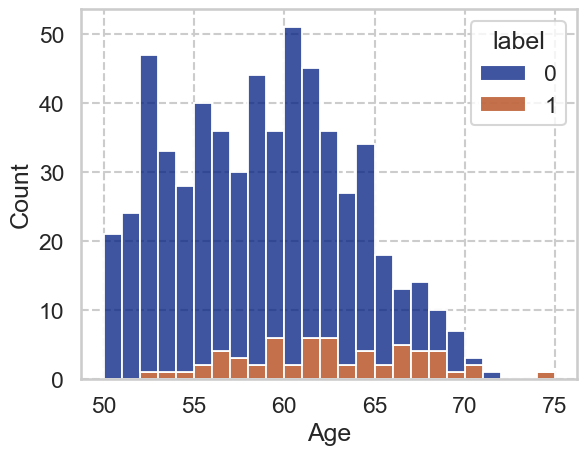

In [7]:
sns.histplot(df_results, x="Age", bins=25, hue="label", multiple='stack')

In [8]:
df_results.query('Age == 70')['label'].value_counts()

label
1    2
0    1
Name: count, dtype: int64

In [9]:
df_malignant = df_results.query('label == 1')
df_malignant.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,59.000000,5.900000e+01,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,2226.067797,2.006203e+07,62.000000,1.457627,0.271186,0.745763,1.711864,0.145046,0.200687,0.222831,0.240233,0.258463,0.307859,0.221539,0.698916,0.616382,1.0
std,1146.619783,1.472711e+04,4.856563,0.502478,0.448388,0.439169,1.175187,0.179729,0.218469,0.226036,0.228718,0.236872,0.248971,0.201549,0.336146,0.273137,0.0
min,62.000000,2.004112e+07,52.000000,1.000000,0.000000,0.000000,1.000000,0.000421,0.002048,0.006331,0.010185,0.014170,0.022664,0.003140,0.000115,0.007771,1.0
25%,1303.500000,2.005072e+07,59.000000,1.000000,0.000000,0.500000,1.000000,0.010938,0.023848,0.040202,0.056078,0.068311,0.104660,0.050493,0.528134,0.474855,1.0
50%,2218.000000,2.005121e+07,62.000000,1.000000,0.000000,1.000000,1.000000,0.084456,0.143517,0.172521,0.197799,0.211975,0.276596,0.167578,0.833620,0.678868,1.0
75%,3300.500000,2.007056e+07,66.000000,2.000000,1.000000,1.000000,2.000000,0.215565,0.306710,0.306925,0.337119,0.365862,0.415215,0.296643,0.971705,0.837449,1.0
max,4032.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,7.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,0.998838,0.977596,1.0


### Define DLCST Splits
DataFrame queries for subsets. Can use this for plots and whatnot.

In [10]:
SPLIT_QUERIES = {
    "sex": {
        "male": 'Sex == 1',
        "female": 'Sex == 2' 
    },
    "family history": {
        "no": 'FamilyHistoryLungCa == 0',
        "yes": 'FamilyHistoryLungCa == 1' 
    },
    "emphysema": {
        "no": 'Emphysema == 0',
        "yes": 'Emphysema == 1' 
    },
    "age": {
        "50-62": '50 <= Age < 62',
        "62+": '62 <= Age', 
    },
    "nodule count": {
        "1": 'NoduleCountPerScan == 1',
        ">1": 'NoduleCountPerScan > 1' 
    }
}

In [11]:
def get_split_dfs(df, split_by="sex", printinfo=True):
    subset_dfs = {}
    for (split, query) in SPLIT_QUERIES[split_by].items():
        subset_dfs[split] = df.query(query)
        
        if printinfo:
            mal_count = len(subset_dfs[split].query('label == 1'))
            mal_percent = 100 * (mal_count / len(subset_dfs[split]))
            print(f"{split}, n={len(subset_dfs[split])}, {mal_count} malignant ({mal_percent:.2f}%)")
    
    return subset_dfs

## ROC Plots

### Compare ROCs across models

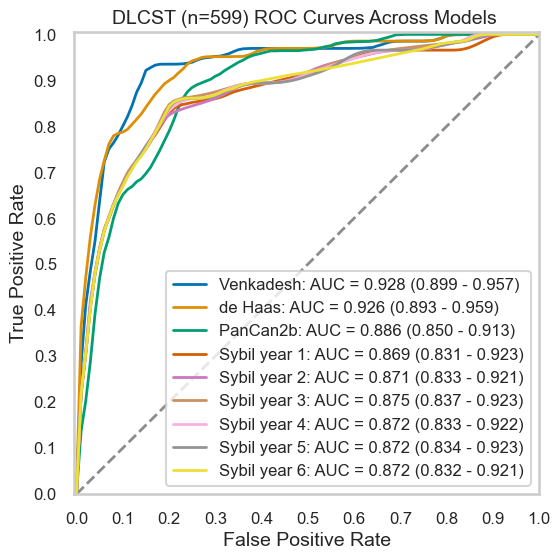

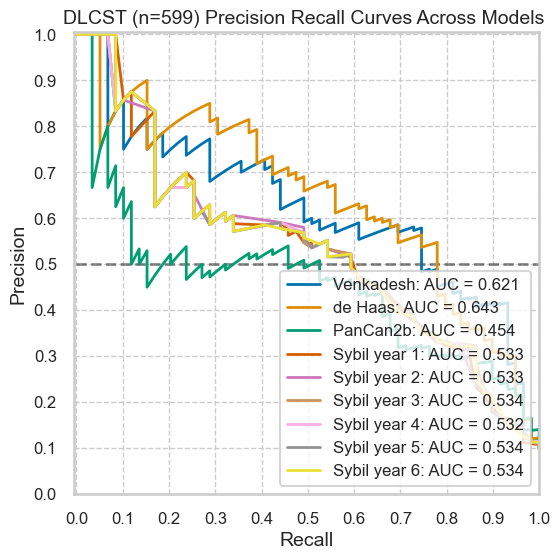

,Venkadesh,de Haas,PanCan2b,Sybil year 1,Sybil year 2,Sybil year 3,Sybil year 4,Sybil year 5,Sybil year 6
score,0.62061,0.643254,0.45385,0.532725,0.533112,0.53438,0.532215,0.533899,0.5342


In [12]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "PanCan2b": "PanCan2b",
    "Sybil year 1": "sybil_year1",
    "Sybil year 2": "sybil_year2",
    "Sybil year 3": "sybil_year3",
    "Sybil year 4": "sybil_year4",
    "Sybil year 5": "sybil_year5",
    "Sybil year 6": "sybil_year6",
}

utils.rocs_models(df_results, models=MODEL_TO_COL,dataset_label='DLCST')
utils.prcs_models(df_results, models=MODEL_TO_COL,dataset_label='DLCST')

### Plot Splits for Same Model

In [13]:
def rocs_splits(df, cat="sex", dataset_label="DLCST", true_col='label', models=MODEL_TO_COL, imgpath=None, plot_ci=False):
    groups = get_split_dfs(df, cat, printinfo=False).items()
    display(Markdown(f"### {cat}"))

    df_catinfo, skips = utils.info_by_splits(groups, 2)
    display(df_catinfo)
    # plot_roc = (0 not in df_catinfo['num_mal']) and (len() not in df_catinfo['pct_mal'])

    rocs = {}
    z = {}
    p = {}
    for m in models:
        rocs[m], df_perf = utils.perf_by_splits(groups, pred_col=MODEL_TO_COL[m])
        z[m], p[m] = utils.hanley_mcneil_sigtest(df_catinfo, skips, rocs[m])

    do_sigtest = (len(df_catinfo) - len(skips)) == 2
    bin_sigtest_results = {}

    fig, ax = plt.subplots(3, len(models) // 3, figsize=(5 * 3 - 0.5, 5 * 3))
    ax = ax.flatten()
    fig.suptitle(f"Model Performance Split By {cat}")
    for i, m in enumerate(models):
        title_str = f"{m} on {dataset_label} (n={len(df)})\nROC by {cat}"
        if do_sigtest:
            z_show, p_show = z[m].iloc[0, 1], p[m].iloc[0, 1]
            title_str = f"{m} on {dataset_label} (n={len(df)})\nROC by {cat} (z={z_show:.2f}, p={p_show:.3f})"
            if p_show < 0.001:
                title_str = f"{m} on {dataset_label} (n={len(df)})\nROC by {cat} (z={z_show:.2f}, p<0.001)"

        utils.ax_rocs(ax[i], rocs[m], title=title_str, catinfo=df_catinfo, plot_ci=True)
    
    plt.tight_layout()
    plt.show()

    df_sigtest_results = None
    if do_sigtest:
        df_sigtest_results = pd.DataFrame(bin_sigtest_results)
    
    display(df_sigtest_results)

    return df_sigtest_results

### sex

,num,pct,num_mal,pct_mal
male,323,53.923205,32,9.907121
female,276,46.076795,27,9.782609


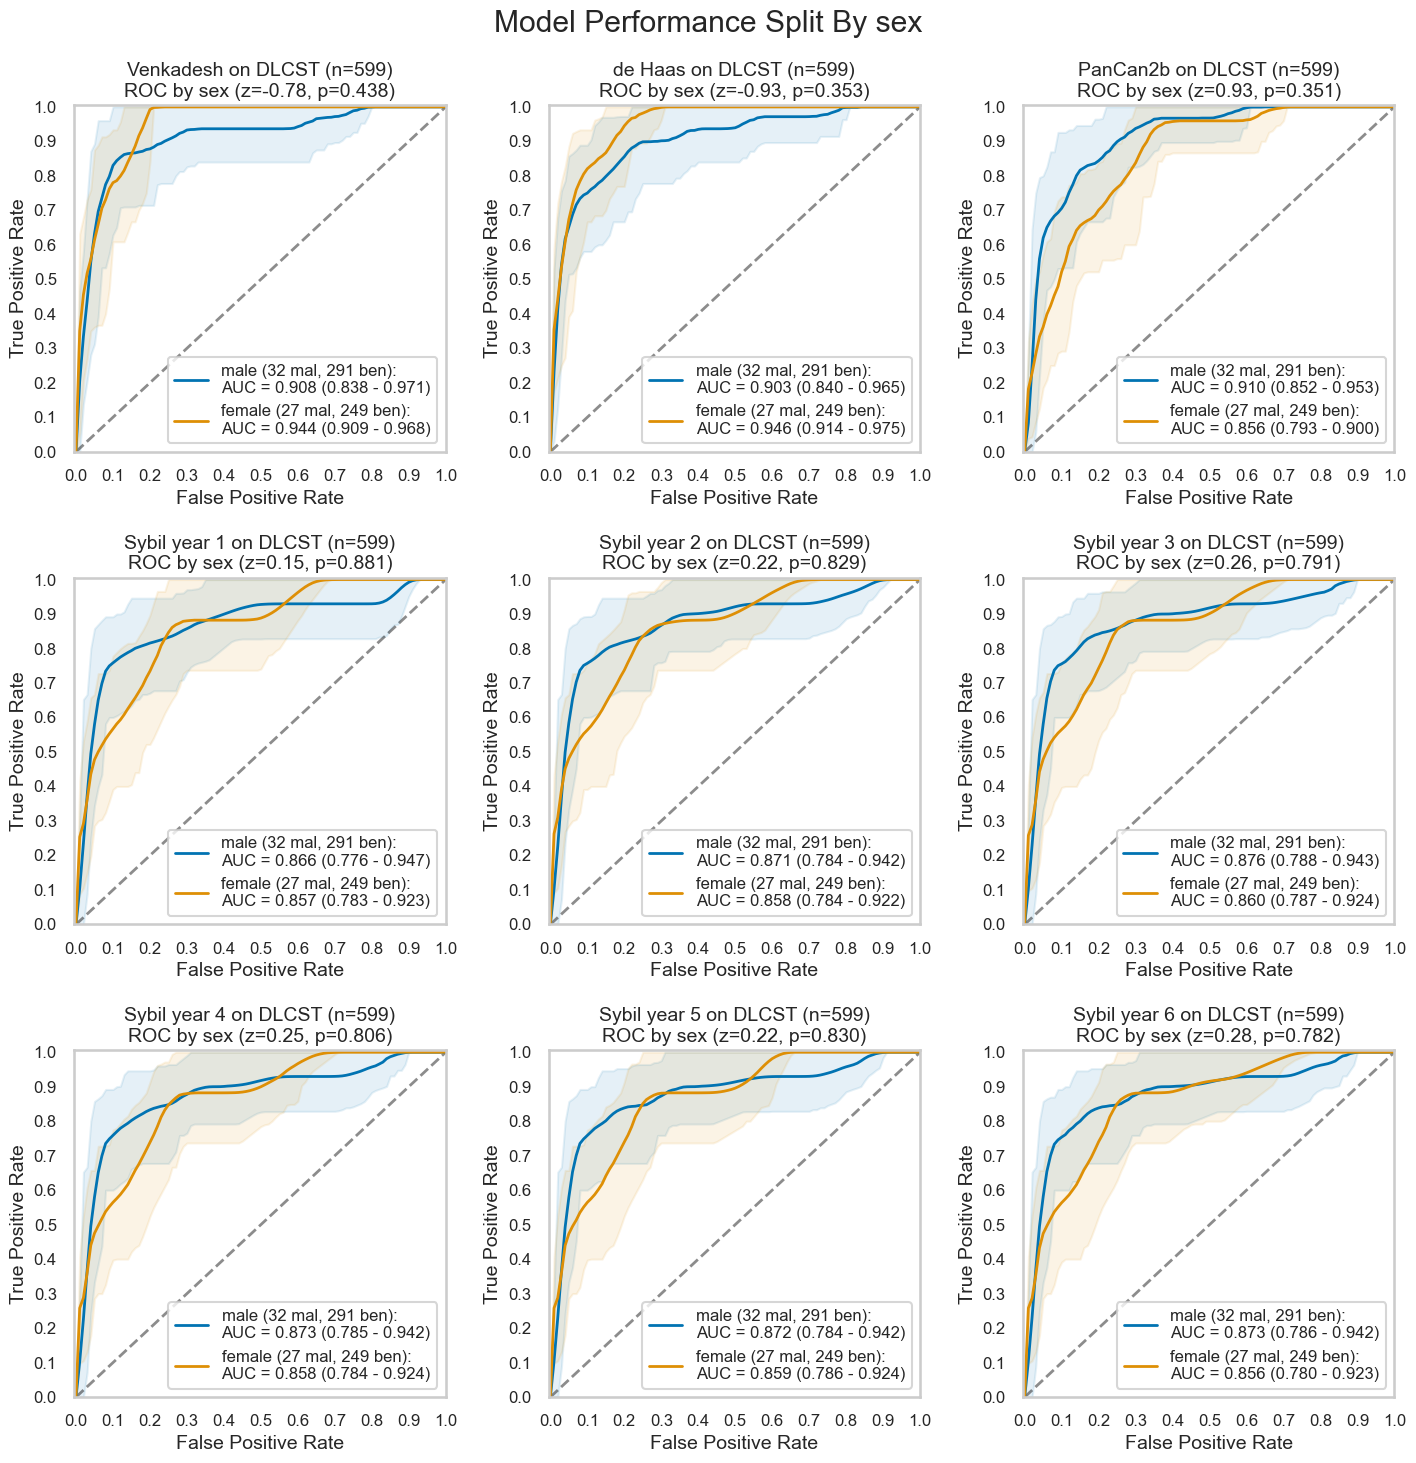

""


### family history

,num,pct,num_mal,pct_mal
no,497,82.971619,43,8.651911
yes,102,17.028381,16,15.686275


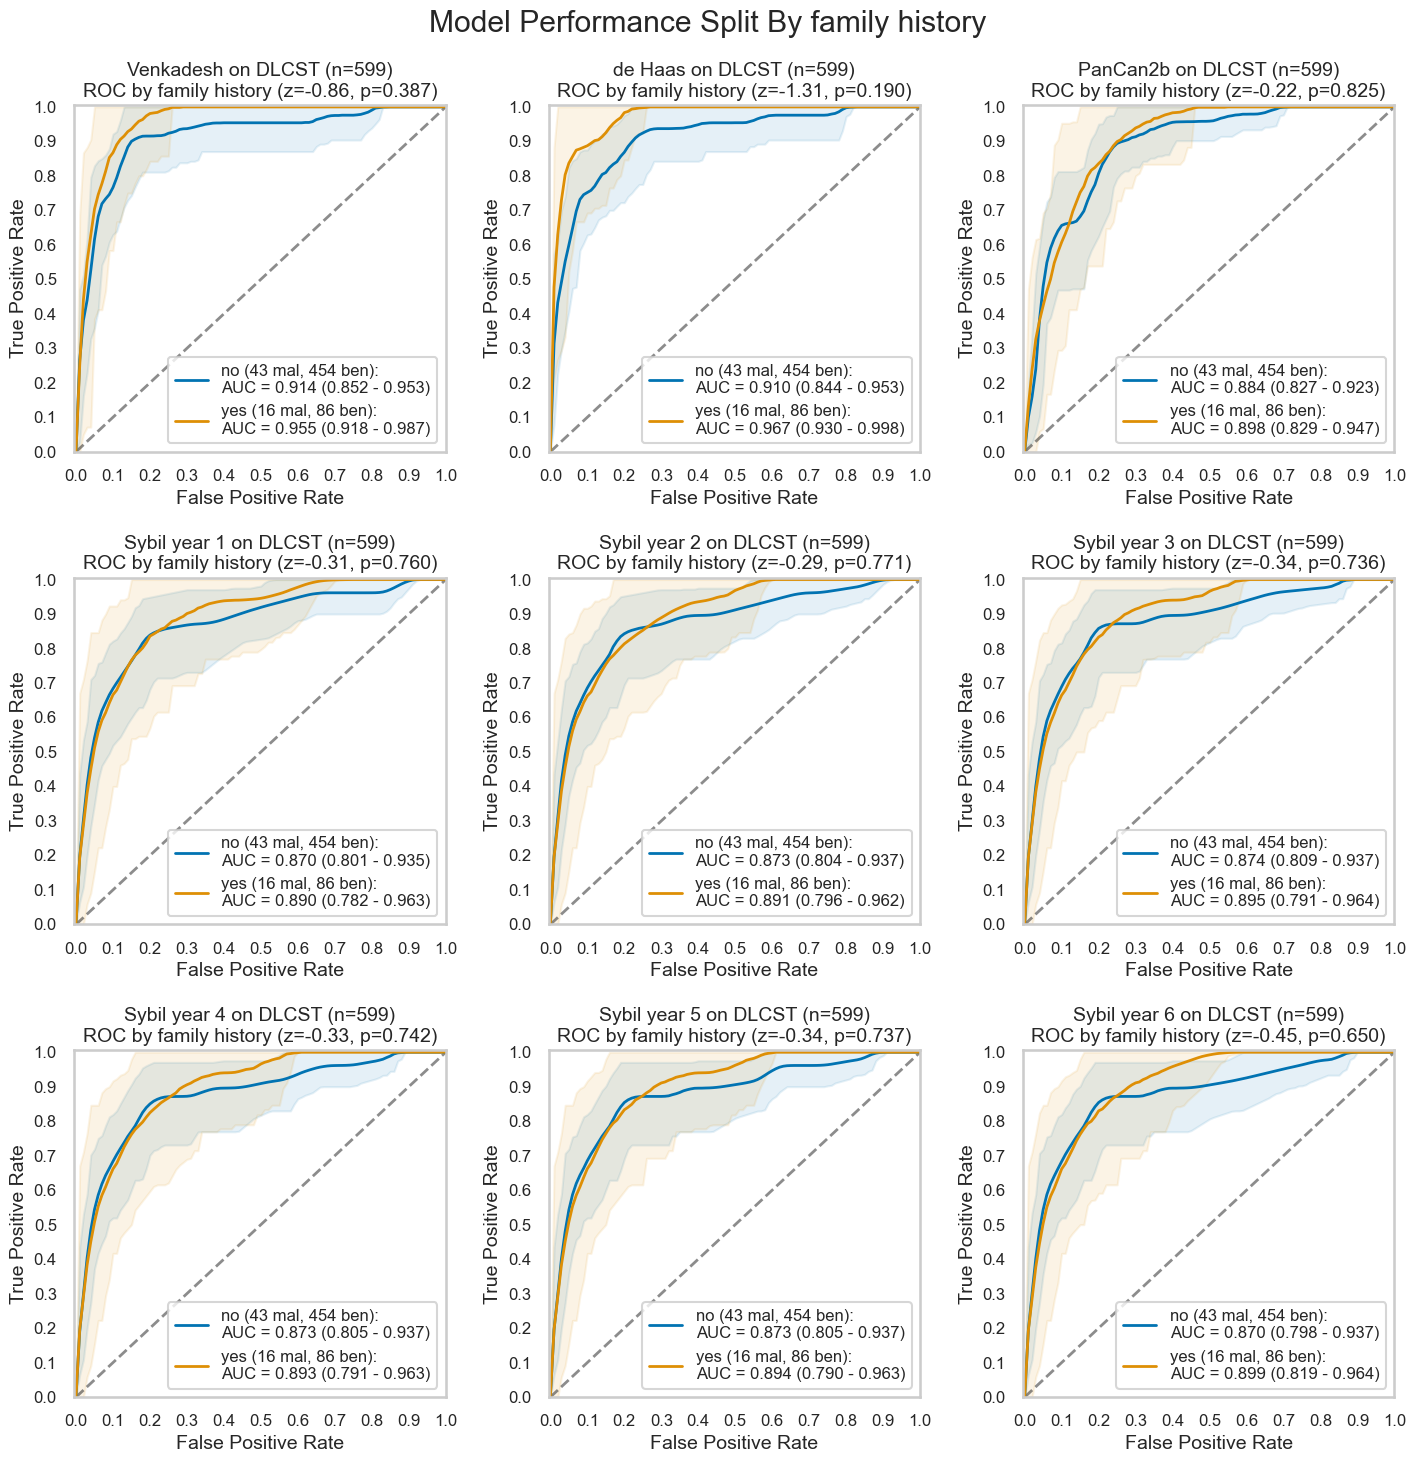

""


### emphysema

,num,pct,num_mal,pct_mal
no,194,32.387312,15,7.731959
yes,405,67.612688,44,10.864198


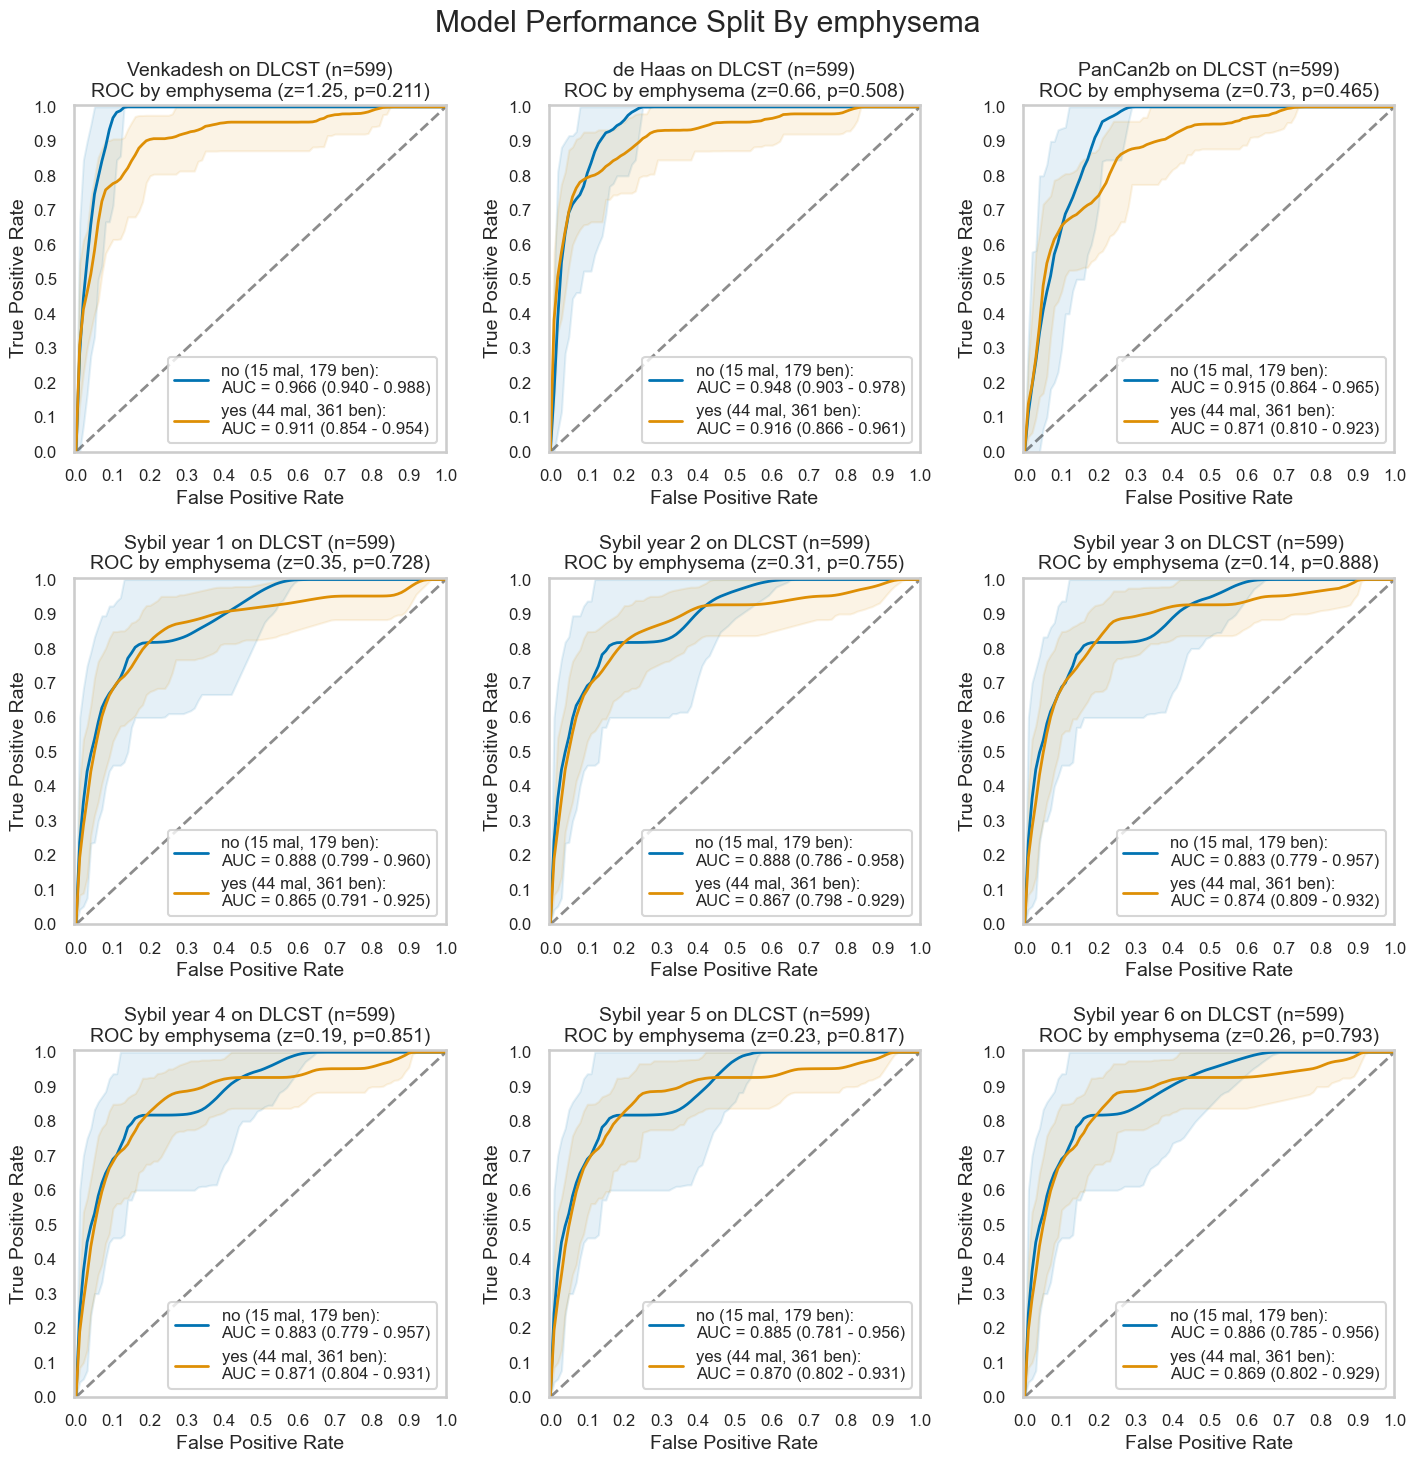

""


### age

,num,pct,num_mal,pct_mal
50-62,435,72.621035,28,6.436782
62+,164,27.378965,31,18.902439


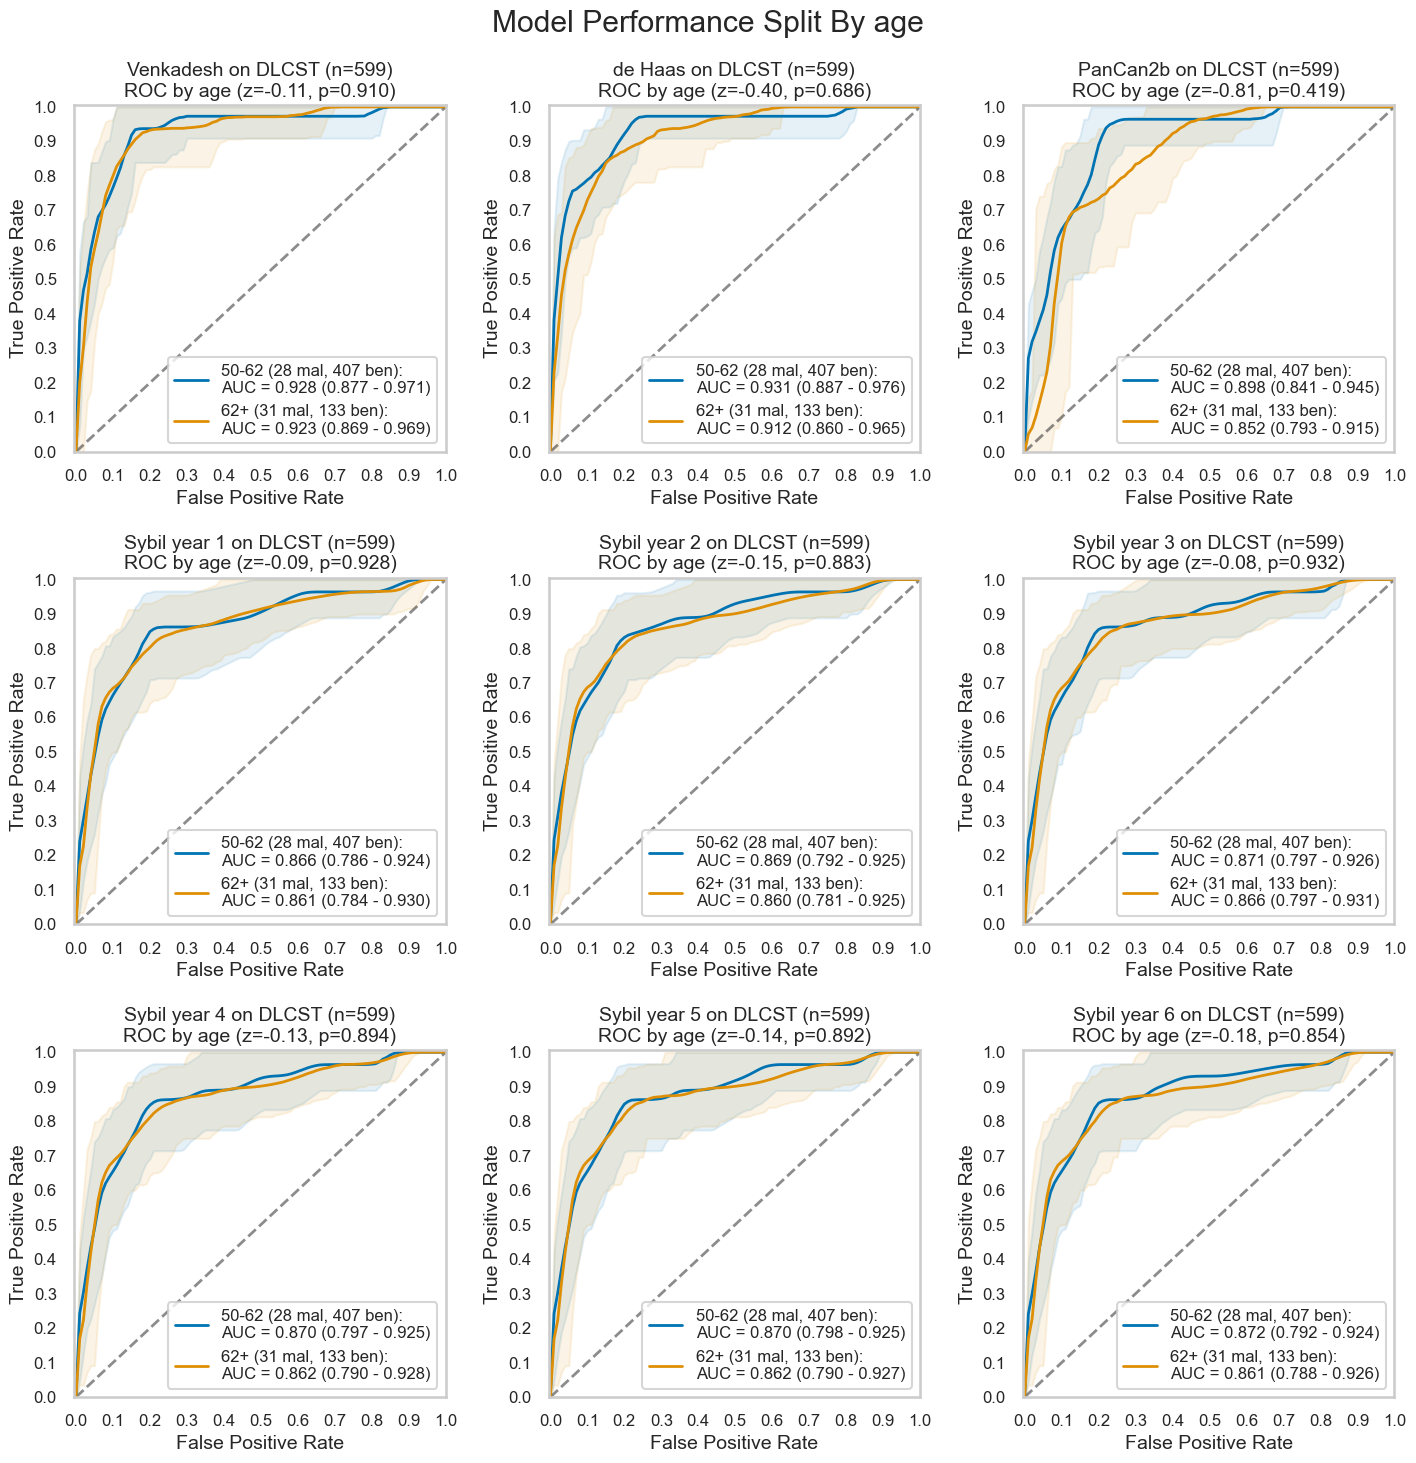

""


### nodule count

,num,pct,num_mal,pct_mal
1,333,55.592654,35,10.510511
>1,266,44.407346,24,9.022556


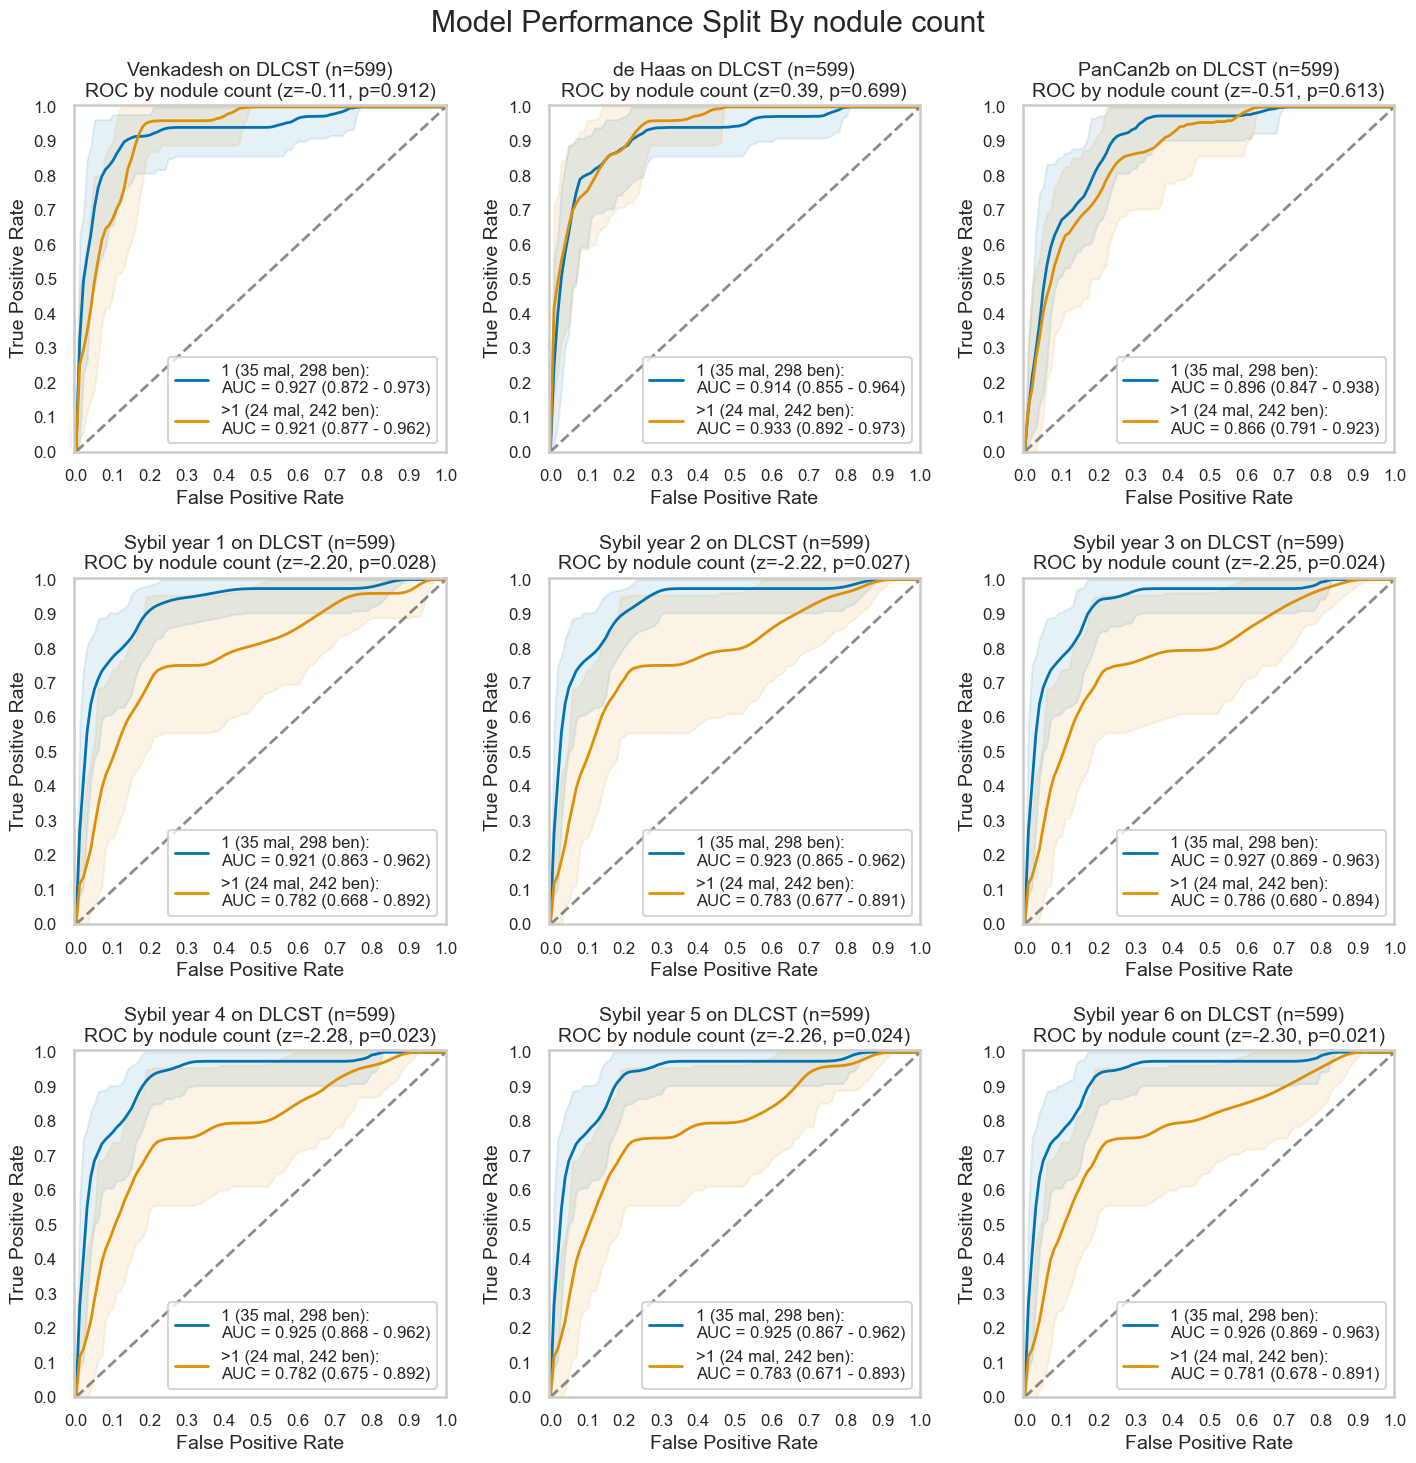

""


In [14]:
for q in SPLIT_QUERIES:
    rocs_splits(df_results, q)